In [51]:
#%pip install mlxtend

In [52]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
import swifter
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier.rocauc import roc_auc
import numpy as np
from yellowbrick.classifier.threshold import discrimination_threshold
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix as mlx_plot_cm
from sklearn.preprocessing import StandardScaler

In [53]:
df = pd.read_excel(r"C:\Users\David gathara marigi\Downloads\default of credit card clients.xls", 
                   skiprows=1, 
                   index_col=0) 
target_col = 'default payment next month' 
features = df.drop(target_col, axis=1) 
targets = df[target_col]

In [54]:
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    targets, 
train_size=0.75,  
stratify=targets)

In [55]:
lr_model = LogisticRegression(max_iter=1000) 
lr_model.fit(x_train, y_train)

c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [56]:
# accuracy

In [57]:
print(lr_model.score(x_train, y_train)) 
print(lr_model.score(x_test, y_test))

0.8070222222222222
0.8098666666666666


In [58]:
df['default payment next month'].value_counts() / df.shape[0]

default payment next month
0    0.7788
1    0.2212
Name: count, dtype: float64

In [59]:
scaler = StandardScaler() 
scaled_features = scaler.fit_transform(features) 
gnb = GaussianNB() 
lr_cv = LogisticRegressionCV() 
lr_cv.fit(features, targets) 
lr_best_c = LogisticRegression(C=lr_cv.C_[0]) 
knn = KNeighborsClassifier()

c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

In [60]:
 
print(cross_val_score(gnb, features, targets, 
n_jobs=-1).mean()) 
print(cross_val_score(lr_best_c, features, targets, 
n_jobs=-1).mean()) 
print(cross_val_score(knn, features, targets, 
n_jobs=-1).mean()) 
print(cross_val_score(knn, scaled_features, targets, 
n_jobs=-1).mean())

0.37909999999999994
0.7786000000000001
0.7553333333333334
0.7915000000000001


In [61]:
cohen_kappa_score(y_test, lr_model.predict(x_test))

np.float64(0.3096070550606288)

In [62]:
print(cross_val_score(lr_model, 
                      features, 
                      targets, 
                      scoring=make_scorer(cohen_kappa_score), 
                      n_jobs=-1).mean())

0.25030753990586163


In [63]:
import matplotlib.pyplot as plt

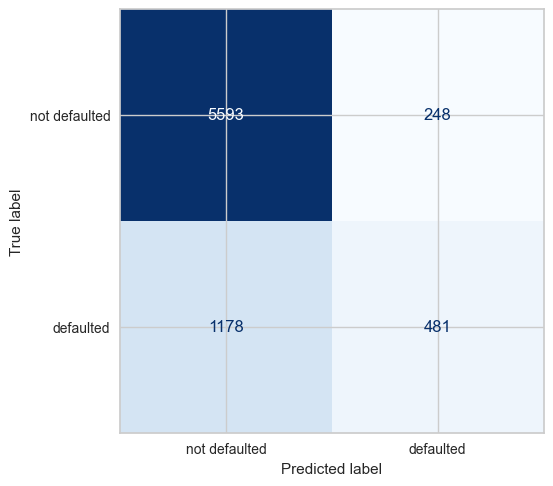

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lr_model, 
                                      x_test, 
                                      y_test, 
                                      cmap=plt.cm.Blues, 
                                      display_labels=['not defaulted', 
                                                       'defaulted'], 
                                      colorbar=False)

In [65]:
pay_0_target = df['PAY_0'].replace({i: 1 for i in range(1, 
9)}) 
pay_0_features = df.drop(['PAY_0', 'default payment next month'], axis=1) 
lr_multi = LogisticRegression(max_iter=1000) 
lr_multi.fit(pay_0_features, pay_0_target)

c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [66]:
from sklearn.metrics import confusion_matrix

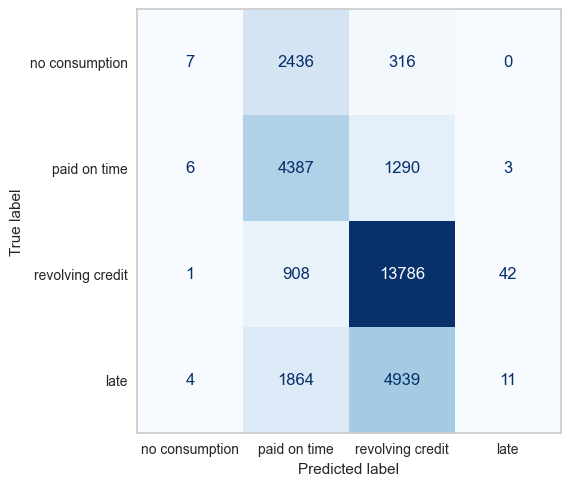

In [67]:
disp = ConfusionMatrixDisplay.from_estimator(lr_multi, 
                                             pay_0_features, 
                                             pay_0_target, 
                                             display_labels=['no consumption', 
                                                             'paid on time',  
                                                             'revolving credit',  
                                                             'late'], 
                                             cmap=plt.cm.Blues, 
                                             colorbar=False)
disp.ax_.grid(False)

In [68]:
pay_cols = ['PAY_0'] + [f'PAY_{i}' for i in range(2, 7)] 
mo_targets = df[pay_cols].copy() 
mo_targets = mo_targets.swifter.apply(lambda x: (x > 
0).astype(int), axis=1) 
mo_features = df[[c for c in df.columns if c not in pay_cols + 
                  ['default payment next month']]]

In [69]:
mo_clf = MultiOutputClassifier(LogisticRegression(max_iter=1000), 
n_jobs=-1) 
mo_clf.fit(mo_features, mo_targets)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000), n_jobs=-1)

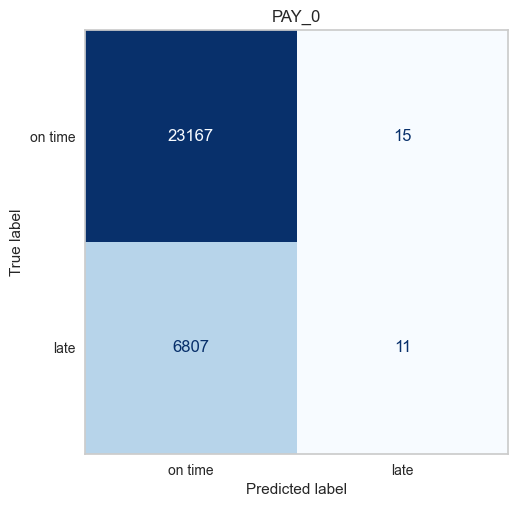

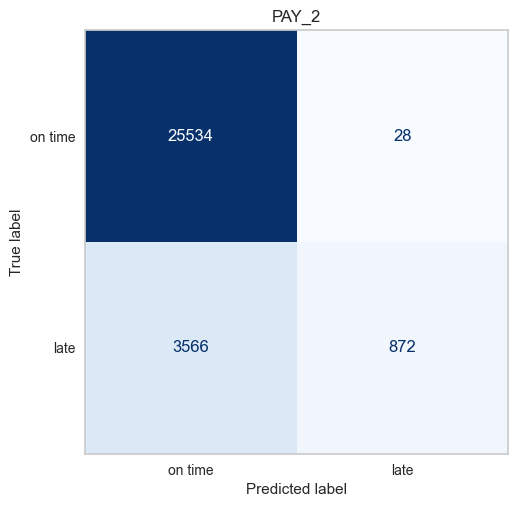

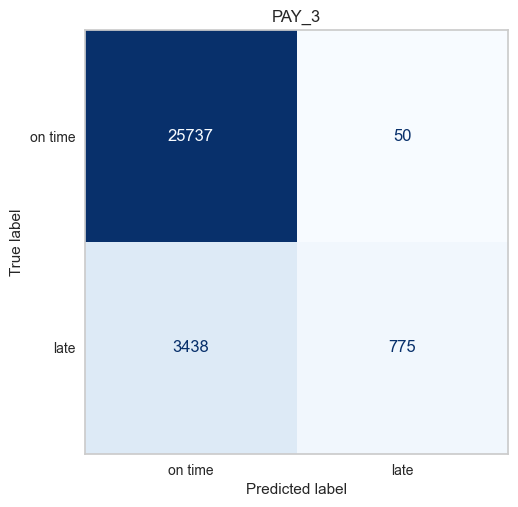

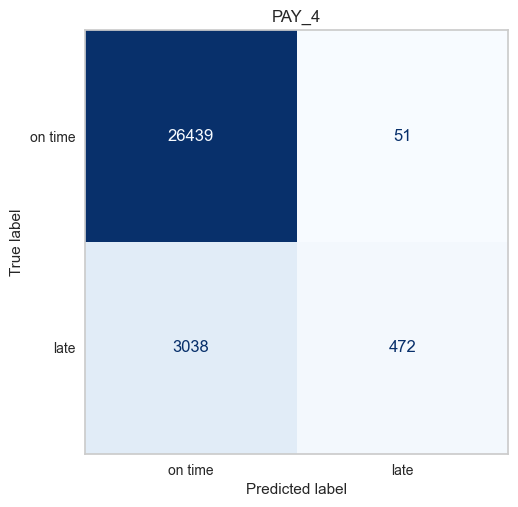

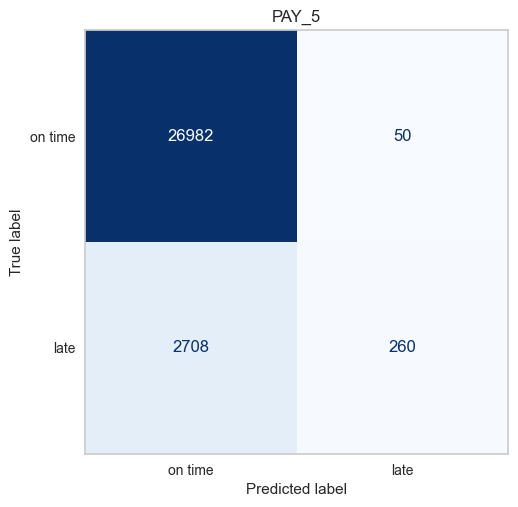

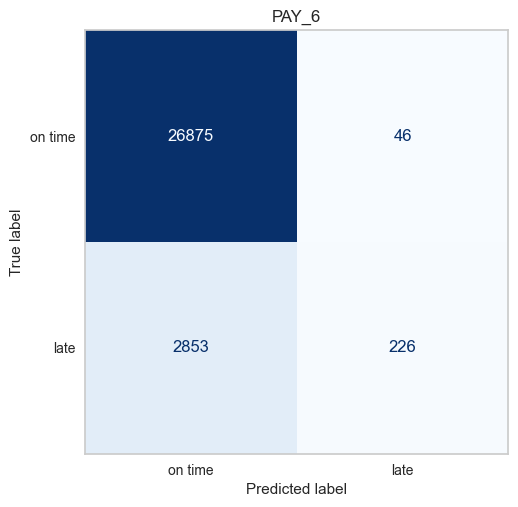

In [70]:
ml_cm = multilabel_confusion_matrix(mo_targets, 
mo_clf.predict(mo_features)) 
for i, cl in enumerate(mo_targets.columns): 
    f = ConfusionMatrixDisplay(ml_cm[i], display_labels=['on time', 'late']) 
    f.plot(cmap=plt.cm.Blues, colorbar=False) 
    plt.title(cl) 
    plt.grid(False)

In [71]:
print(classification_report(y_test, 
                            lr_model.predict(x_test), 
                            target_names=['no default', 
'default']))

              precision    recall  f1-score   support

  no default       0.83      0.96      0.89      5841
     default       0.66      0.29      0.40      1659

    accuracy                           0.81      7500
   macro avg       0.74      0.62      0.64      7500
weighted avg       0.79      0.81      0.78      7500



c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


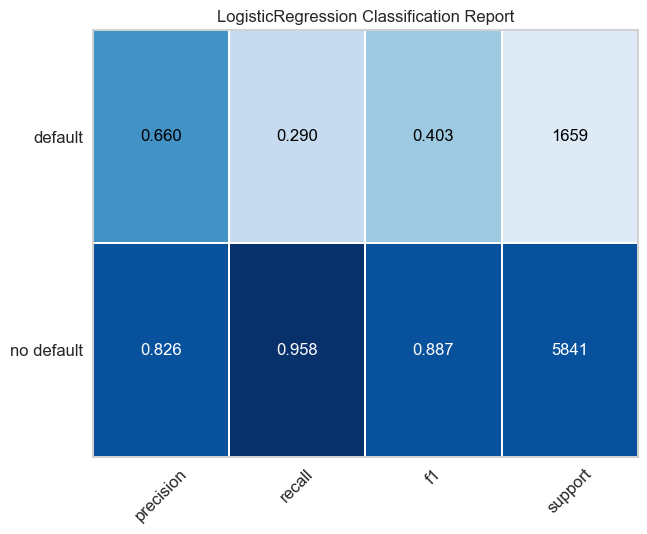

<Axes: title={'center': 'LogisticRegression Classification Report'}>

In [72]:
f, ax = plt.subplots(1, 1) 
viz = ClassificationReport(lr_model, 
                           support=True, 
                           classes=['no default', 'default'], 
                           cmap='Blues') 
viz.score(x_test, y_test) 
plt.gcf().delaxes(f.axes[1]) 
viz.show()

In [73]:
print(classification_report(pay_0_target, 
                            lr_multi.predict(pay_0_features), 
                            target_names=['no consumption', 
                                          'on time', 
                                          'credit', 
                                          'late'] 
                           ) 
     )

                precision    recall  f1-score   support

no consumption       0.39      0.00      0.01      2759
       on time       0.46      0.77      0.57      5686
        credit       0.68      0.94      0.79     14737
          late       0.20      0.00      0.00      6818

      accuracy                           0.61     30000
     macro avg       0.43      0.43      0.34     30000
  weighted avg       0.50      0.61      0.50     30000



c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


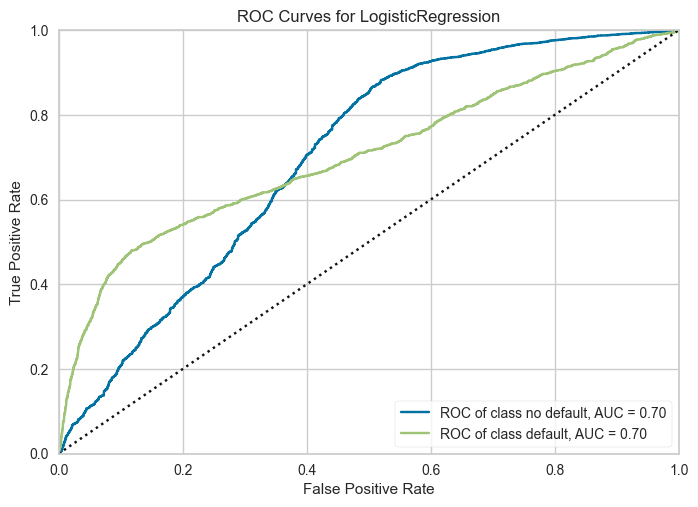

In [74]:
roc = roc_auc(lr_model, 
              x_train, 
              y_train, 
              x_test, 
              y_test, 
              classes=['no default', 'default'], 
              macro=False, 
              micro=False)

c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


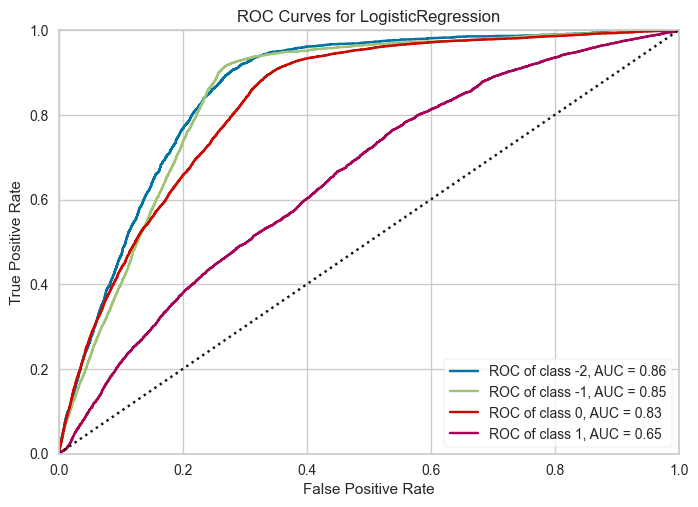

In [75]:
roc = roc_auc(lr_multi, 
              pay_0_features, 
              pay_0_target, 
              macro=False, 
              micro=False)

c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


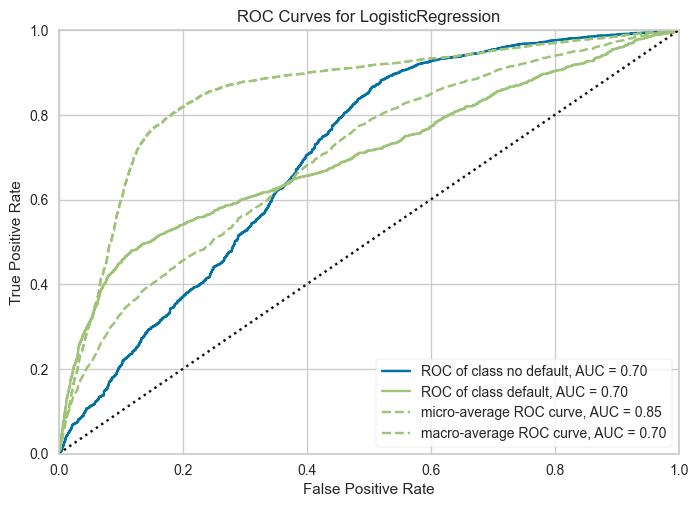

In [76]:
roc = roc_auc(lr_model, 
              x_train, 
              y_train, 
              x_test, 
              y_test, 
              classes=['no default', 'default'])

In [77]:
from sklearn.metrics import RocCurveDisplay

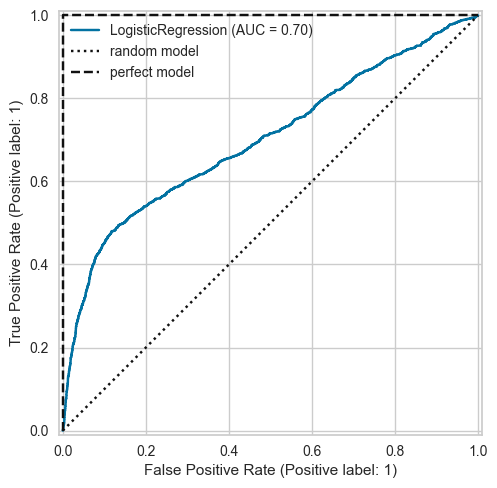

In [78]:
roc = RocCurveDisplay.from_estimator(lr_model, x_test, y_test) 
plt.plot([0, 1], [0, 1], c='k', linestyle='dotted', label='random model') 
plt.plot([0, 0, 1], [0, 1, 1], c='k', linestyle='dashed', label='perfect model') 
plt.legend()

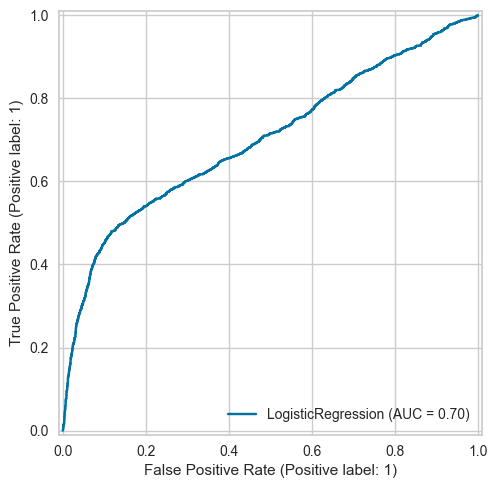

In [79]:
roc = RocCurveDisplay.from_estimator(lr_model, x_test, y_test, drop_intermediate=False)
youdens_idx = np.argmax(roc.tpr - roc.fpr) 
thresholds = np.unique(lr_model.predict_proba(x_test)[:, 1]) 
thresholds.sort() 
thresholds = [1] + list(thresholds[::-1])  
y_thresh = thresholds[youdens_idx]

In [80]:
upper_left_array = np.vstack((np.zeros(roc.tpr.shape[0]), 
                              np.ones(roc.tpr.shape[0]))).T 
roc_curve_points = np.vstack((roc.fpr, roc.tpr)).T 
topleft_idx = np.argmin(np.linalg.norm(upper_left_array - 
roc_curve_points, 
                                       axis=1)) 
tl_thresh = thresholds[topleft_idx]

c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

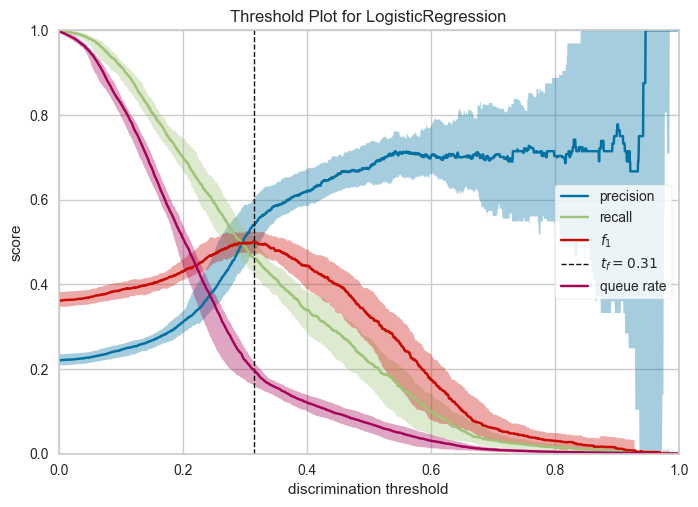

In [81]:
dt = discrimination_threshold(lr_model, x_train, y_train) 
f_idx = dt.cv_scores_['fscore'].argmax() 
f_thresh = dt.thresholds_[f_idx]

In [82]:
for t in [y_thresh, tl_thresh, f_thresh]: 
    print(accuracy_score(y_test, 
lr_model.predict_proba(x_test)[:, 1] >= t))

0.7932
0.6989333333333333
0.7838666666666667


In [83]:
from mlxtend.plotting import plot_confusion_matrix as mlx_plot_cm 

(<Figure size 800x550 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

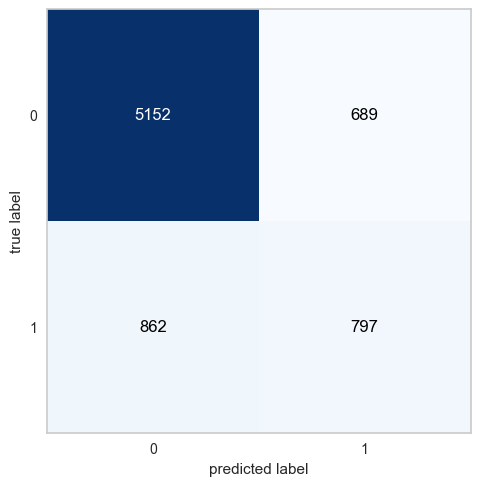

In [84]:
predictions = lr_model.predict_proba(x_test)[:, 1] >= y_thresh 
mlx_plot_cm(confusion_matrix(y_test, predictions))

In [85]:
# downsampling

In [86]:
_, x_sample, _, y_sample = train_test_split(features, 
                                            targets, 
                                            test_size=0.1, 
                                            stratify=targets, 
                                            random_state=42)

In [87]:
from imblearn.under_sampling import RandomUnderSampler

In [88]:
rus = RandomUnderSampler(random_state=0) 
x_resampled, y_resampled = rus.fit_resample(features, targets)

In [89]:
# oversampling

In [90]:
from sklearn.metrics import roc_auc_score 
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=0) 
x_resampled, y_resampled = ros.fit_resample(x_train, y_train) 
lr_model = LogisticRegressionCV(max_iter=5000) 
lr_model.fit(x_train, y_train)
print('unmodified:', 
      roc_auc_score(y_test, 
                    lr_model.predict_proba(x_test)[:, 1]) 
     ) 
lr_model_rs = LogisticRegressionCV(max_iter=1000) 
lr_model_rs.fit(x_resampled, y_resampled) 
print('resampled:', 
      roc_auc_score(y_test, 
                    lr_model_rs.predict_proba(x_test)[:, 1]) 
     ) 

c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

unmodified: 0.7210631668902426


c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

resampled: 0.7221321829774952


c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [92]:
from imblearn.over_sampling import KMeansSMOTE

In [ ]:
kmSMOTE = KMeansSMOTE(k_neighbors=5, 
                      cluster_balance_threshold=0.2, 
                      random_state=42, 
                      n_jobs=-1) 
x_resampled, y_resampled = kmSMOTE.fit_resample(x_train, 
y_train) 
lr_model_rs = LogisticRegressionCV(max_iter=5000) 
lr_model_rs.fit(x_resampled, y_resampled) 
print('resampled:', roc_auc_score(y_test, lr_model_rs.predict_proba(x_test)[:, 1]))

c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\David gathara marigi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

In [ ]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN 
from imblearn.combine import SMOTEENN, SMOTETomek

In [ ]:
samplers = [ 
    SMOTE(random_state=42), 
    BorderlineSMOTE(random_state=42, kind="borderline-1"), 
    BorderlineSMOTE(random_state=42, kind="borderline-2"), 
    SVMSMOTE(random_state=42), 
    ADASYN(random_state=42), 
    SMOTEENN(random_state=42), 
    SMOTETomek(random_state=42) 
]

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
x_test_scaled = scaler.transform(x_test.astype(np.float64))


In [ ]:
for s in samplers:
    x_resampled, y_resampled = s.fit_resample(x_train_scaled, y_train)
    lr_model_rs = LogisticRegressionCV(max_iter=5000, solver='saga', tol=1e-3)
    lr_model_rs.fit(x_resampled, y_resampled)
    ra_score = roc_auc_score(y_test, lr_model_rs.predict_proba(x_test_scaled)[:, 1])
    print(f'{str(s):<55} {ra_score}')